# 1. Objetivos del EDA

- Describir el problema y el dataset.
- Analizar la distribución de clases y la calidad de las anotaciones.
- Visualizar imágenes y bounding boxes.
- Analizar tamaños y proporciones de las cajas.
- Detectar posibles problemas (desbalance, imágenes corruptas, etc).

In [3]:
import os
import glob
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os, yaml, random, numpy as np
import kagglehub  # Library to download datasets from Kaggle



In [4]:
# Create a directory for the dataset if it doesn't exist
os.makedirs("./data/xray", exist_ok=True)
# Download the dataset from Kaggle using kagglehub
path = kagglehub.dataset_download("orvile/x-ray-baggage-anomaly-detection")

print("Path to dataset files:", path)  # Print the path where the dataset was downloaded

Path to dataset files: /Users/sebastiancarreras/.cache/kagglehub/datasets/orvile/x-ray-baggage-anomaly-detection/versions/1


In [21]:
# definos los directorios de imágenes y etiquetas
images_dir = path +"/train/images/"
labels_dir = path + "/train/labels/"
print("Path to images:", images_dir)  # Print the path to the images directory
print("Path to labels:", labels_dir)  # Print the path to the labels directory
# Cargamos el archivo YAML para obtener los nombres de las clases
with open(f"{path}/data.yaml", 'r') as file: data = yaml.safe_load(file)      
# Extract class names
class_names = data['names']
class_names


Path to images: /Users/sebastiancarreras/.cache/kagglehub/datasets/orvile/x-ray-baggage-anomaly-detection/versions/1/train/images/
Path to labels: /Users/sebastiancarreras/.cache/kagglehub/datasets/orvile/x-ray-baggage-anomaly-detection/versions/1/train/labels/


['0', '1', '2', '3', '4']

In [22]:
# 1. Distribución de clases y cantidad de objetos por imagen
class_counts = Counter()
objects_per_image = []
bbox_areas = []
bbox_ratios = []

# Obtenemos la lista de archivos de etiquetas
label_files = sorted(glob.glob(os.path.join(labels_dir, "*.txt")))
print("Label files:", label_files)  # Print the list of label files
# Recorremos cada archivo de etiquetas 
for label_file in label_files:
    with open(label_file, "r") as f:
        lines = f.readlines()
        objects_per_image.append(len(lines))
        for line in lines:
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center, y_center, width, height = map(float, parts[1:])
            class_counts[class_id] += 1
            bbox_areas.append(width * height)
            bbox_ratios.append(width / height if height > 0 else 0)

print("boxes", bbox_areas)
print("boxes ratios", bbox_ratios) 
print("boxes counts", class_counts)


Label files: ['/Users/sebastiancarreras/.cache/kagglehub/datasets/orvile/x-ray-baggage-anomaly-detection/versions/1/train/labels/009000_jpg.rf.8c46e1aa5b46a0ad24ee4bcb2945d22a.txt', '/Users/sebastiancarreras/.cache/kagglehub/datasets/orvile/x-ray-baggage-anomaly-detection/versions/1/train/labels/009002_jpg.rf.18bf80f2cfdb51f853da15019f787cef.txt', '/Users/sebastiancarreras/.cache/kagglehub/datasets/orvile/x-ray-baggage-anomaly-detection/versions/1/train/labels/009003_jpg.rf.46963402c4cb6f46a47e508b892c6521.txt', '/Users/sebastiancarreras/.cache/kagglehub/datasets/orvile/x-ray-baggage-anomaly-detection/versions/1/train/labels/009007_jpg.rf.a5143afbb0c741f3b60fc72403fdde6a.txt', '/Users/sebastiancarreras/.cache/kagglehub/datasets/orvile/x-ray-baggage-anomaly-detection/versions/1/train/labels/009012_jpg.rf.bc99877ade8754d2be89119361e7820c.txt', '/Users/sebastiancarreras/.cache/kagglehub/datasets/orvile/x-ray-baggage-anomaly-detection/versions/1/train/labels/009013_jpg.rf.87d247bf389dbfa84

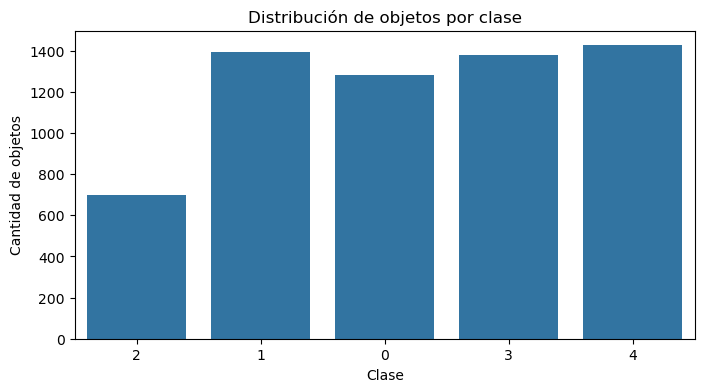

In [24]:
# 2. Visualización de distribución de clases
plt.figure(figsize=(8,4))
sns.barplot(x=[class_names[i] for i in class_counts.keys()], y=list(class_counts.values()))
plt.title("Distribución de objetos por clase")
plt.xlabel("Clase")
plt.ylabel("Cantidad de objetos")
plt.show()


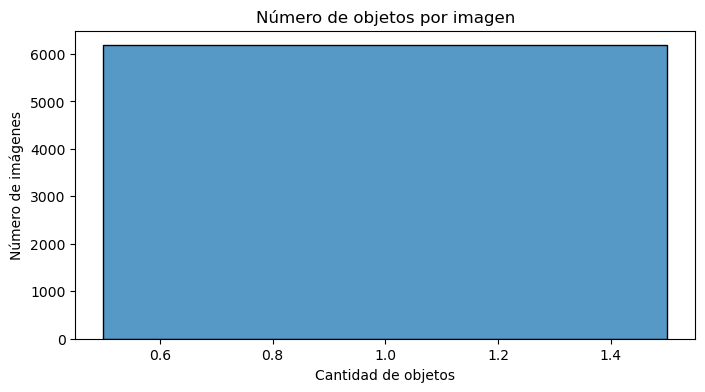

In [25]:
# 3. Número de objetos por imagen
if objects_per_image:
    plt.figure(figsize=(8,4))
    sns.histplot(objects_per_image, bins=range(1, max(objects_per_image)+2), discrete=True)
    plt.title("Número de objetos por imagen")
    plt.xlabel("Cantidad de objetos")
    plt.ylabel("Número de imágenes")
    plt.show()
else:
    print("No hay objetos por imagen para mostrar.")


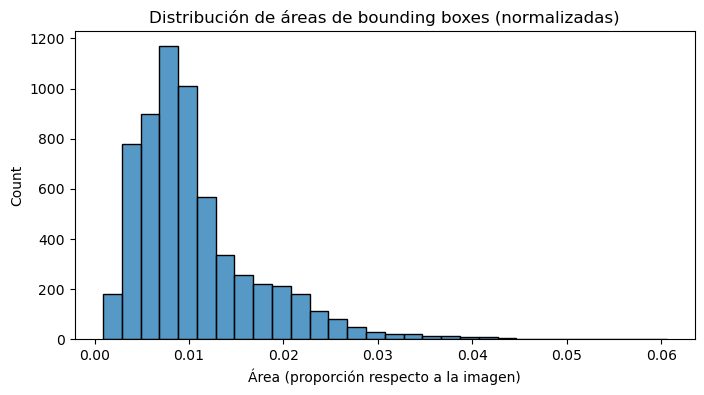

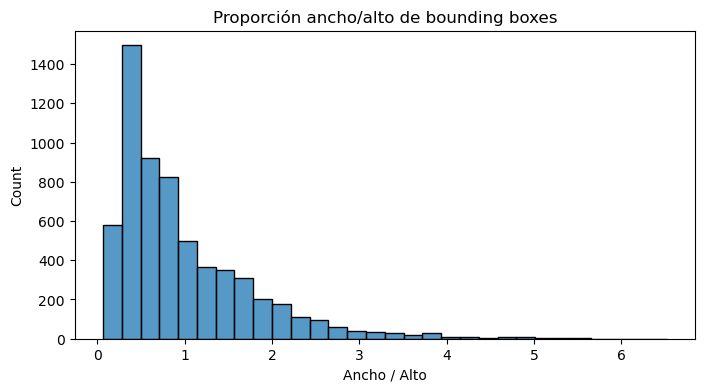

In [26]:
# 4. Distribución de áreas y proporciones de bounding boxes
plt.figure(figsize=(8,4))
sns.histplot(bbox_areas, bins=30)
plt.title("Distribución de áreas de bounding boxes (normalizadas)")
plt.xlabel("Área (proporción respecto a la imagen)")
plt.show()

plt.figure(figsize=(8,4))
sns.histplot(bbox_ratios, bins=30)
plt.title("Proporción ancho/alto de bounding boxes")
plt.xlabel("Ancho / Alto")
plt.show()

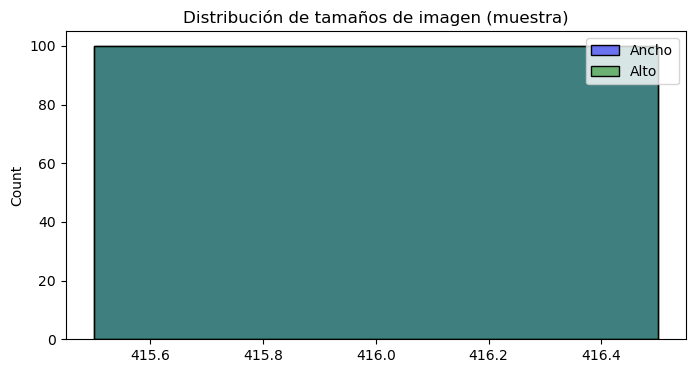

In [27]:
# 5. Tamaño de imágenes (opcional, si tienes muchas imágenes, toma una muestra)
image_files = sorted(glob.glob(os.path.join(images_dir, "*.jpg")))
sampled_images = image_files[:100]
sizes = []
for img_path in sampled_images:
    with Image.open(img_path) as img:
        sizes.append(img.size)
if sizes:
    widths, heights = zip(*sizes)
    plt.figure(figsize=(8,4))
    sns.histplot(widths, color='blue', label='Ancho', kde=True)
    sns.histplot(heights, color='green', label='Alto', kde=True)
    plt.legend()
    plt.title("Distribución de tamaños de imagen (muestra)")
    plt.show()


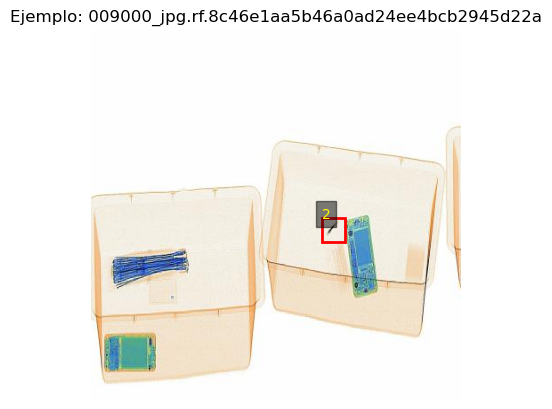

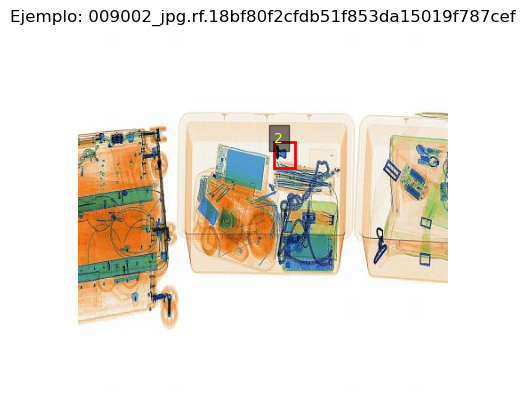

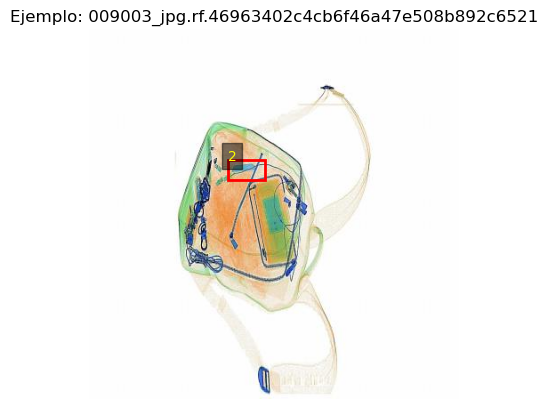

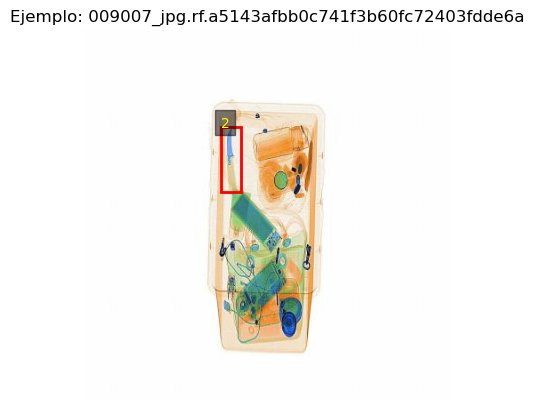

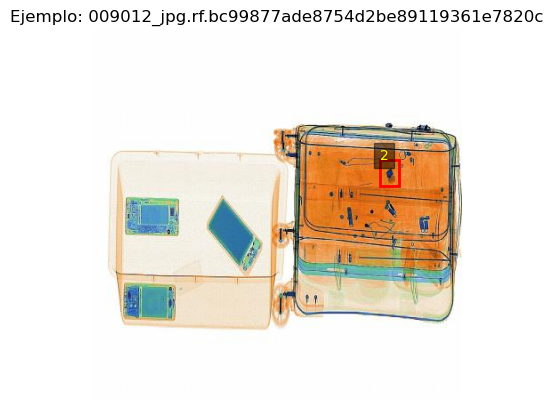

In [28]:
# 6. Visualización de ejemplos con bounding boxes
import matplotlib.patches as patches

for img_path in sampled_images[:5]:
    img_name = os.path.splitext(os.path.basename(img_path))[0]
    label_path = os.path.join(labels_dir, f"{img_name}.txt")
    img = Image.open(img_path)
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    w_img, h_img = img.size
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                class_id = int(parts[0])
                x_center, y_center, width, height = map(float, parts[1:])
                # Convertir a píxeles
                x = (x_center - width / 2) * w_img
                y = (y_center - height / 2) * h_img
                w = width * w_img
                h = height * h_img
                rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                ax.text(x, y, class_names[class_id], color='yellow', fontsize=10, bbox=dict(facecolor='black', alpha=0.5))
    plt.title(f"Ejemplo: {img_name}")
    plt.axis('off')
    plt.show()